# Basic Model Methods Demonstration

Comparison of Lifetime Reward (LR), Euler Residual (ER), and Bellman Residual (BR) methods.

**Key Difference**: 
- **LR Method**: Uses trajectory data (N samples, T+1 timesteps)
- **ER/BR Methods**: Use flattened i.i.d. data (N×T independent transitions)

This notebook demonstrates:
1. Data generation in both formats
2. Training all three methods
3. Loss curves and convergence comparison
4. Policy function comparison
5. Target network update monitoring (ER/BR only)

In [27]:

import sys
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# Add project root to path
sys.path.append(os.path.abspath(".."))

from src.economy.data_generator import create_data_generator
from src.economy.parameters import EconomicParams, ShockParams
from src.trainers.config import NetworkConfig, OptimizationConfig, AnnealingConfig, MethodConfig, EarlyStoppingConfig, RiskyDebtConfig
from src.trainers.basic import train_basic_lr, train_basic_er, train_basic_br
from src.utils.plotting import plot_loss_comparison, plot_scenario_comparison, display_moments_table
from src.utils.analysis import evaluate_policy



In [28]:
# 1. Configuration

# Economic Parameters (simplified for demonstration)
params = EconomicParams.with_overrides(
    cost_convex = 0.01,
    cost_fixed = 0.0,
    cost_inject_fixed = 0.0,
    cost_inject_linear = 0.0    
)

# AR(1) shock params
shock_params = ShockParams(mu=0.0, rho=0.7, sigma=0.15)

# Network Config (Small for speed)
net_config = NetworkConfig(
    n_layers=2,
    n_neurons=16,
    activation="swish"  # SiLU activation for stability
)

# Annealing Config
anneal_config = AnnealingConfig(
    temperature_init=1.0,
    temperature_min=1e-4,
    decay=0.99    # Set small decay for slower annealing
)

# Early stopping config
early_stopping_config = EarlyStoppingConfig(
    enabled=True,           # Enable early stopping (False = run exactly n_iter)
    patience=5,             # Stop after 5 consecutive checks meeting criteria
    eval_freq=50,          # Check convergence every 100 iterations
    
    # LR Method: Relative Improvement Plateau
    lr_epsilon=1e-4,        # Relative improvement threshold
    lr_window=50,          # Window size for improvement evaluation
    
    # ER Method: Zero-Tolerance Plateau  
    er_epsilon=1e-5,        # Absolute loss threshold
    
    # BR Method: Dual-Condition Convergence
    br_critic_epsilon=1e-5, # Critic loss threshold
    br_actor_epsilon=1e-4   # Actor relative improvement threshold
)

# Optimization Config (with early stopping)
opt_config = OptimizationConfig(
    learning_rate=1e-4,
    learning_rate_critic=2e-3,  # BR only, should be > actor learning rate
    batch_size=512,
    n_iter=500,            # Max iterations (will stop early if converged)
    log_every=10,
    early_stopping=early_stopping_config
)


print("--- Configuration set ---")
print(f"  Network: {net_config.n_layers} layers × {net_config.n_neurons} neurons")
print(f"  Training: {opt_config.n_iter} iterations, batch size {opt_config.batch_size}")
print(f"  Early Stopping: {'enabled' if early_stopping_config.enabled else 'disabled'}")
print(f"  Patience: {early_stopping_config.patience}, Eval Freq: {early_stopping_config.eval_freq}")

--- Configuration set ---
  Network: 2 layers × 16 neurons
  Training: 500 iterations, batch size 512
  Early Stopping: enabled
  Patience: 5, Eval Freq: 50


In [29]:
import dataclasses
from pprint import pprint

# Comprehensive preview of the configs
print("--- Economic Parameters ---")
pprint(dataclasses.asdict(params))

print("\n--- Shock Parameters ---")
pprint(dataclasses.asdict(shock_params))

print("\n--- Network Config ---")
pprint(dataclasses.asdict(net_config))

print("\n--- Optimization Config ---")
pprint(dataclasses.asdict(opt_config))

print("\n--- Annealing Config ---")
pprint(dataclasses.asdict(anneal_config))

--- Economic Parameters ---
{'cost_convex': 0.01,
 'cost_default': 0.4,
 'cost_fixed': 0.0,
 'cost_inject_fixed': 0.0,
 'cost_inject_linear': 0.0,
 'delta': 0.15,
 'frac_liquid': 0.5,
 'r_rate': 0.04,
 'tax': 0.3,
 'theta': 0.7}

--- Shock Parameters ---
{'mu': 0.0, 'rho': 0.7, 'sigma': 0.15}

--- Network Config ---
{'activation': 'swish', 'n_layers': 2, 'n_neurons': 16}

--- Optimization Config ---
{'batch_size': 512,
 'early_stopping': {'br_actor_epsilon': 0.0001,
                    'br_critic_epsilon': 1e-05,
                    'enabled': True,
                    'er_epsilon': 1e-05,
                    'eval_freq': 50,
                    'lr_epsilon': 0.0001,
                    'lr_window': 50,
                    'ma_window': 20,
                    'patience': 5},
 'learning_rate': 0.0001,
 'learning_rate_critic': 0.002,
 'log_every': 10,
 'n_iter': 500}

--- Annealing Config ---
{'decay': 0.99,
 'logit_clip': 20.0,
 'schedule': 'exponential',
 'temperature_init': 1.0,
 'tem

In [30]:
# 1. Clean up cache dataset and figures from previous runs

from pathlib import Path

# Config: Directories to clean -> List of extensions for each
cleanup_targets = {
    "../data":    ["*.npz", "*.png"],
    "../figures": ["*.png", "*.jpg"],
    # Add more paths as needed: "../logs": ["*.log"]
}

for dir_path, patterns in cleanup_targets.items():
    directory = Path(dir_path)
    if directory.exists():
        for pattern in patterns:
            # Using glob to safely find files matching pattern
            for f in directory.glob(pattern):
                try:
                    f.unlink()
                    print(f"Deleted: {f}") # Uncomment for verbose output
                except OSError as e:
                    print(f"Error deleting {f}: {e}")

Deleted: ../data/validation_0e6379abb28a.npz
Deleted: ../data/training_flattened_0e6379abb28a.npz
Deleted: ../data/validation_flattened_0e6379abb28a.npz
Deleted: ../data/training_0e6379abb28a.npz
Deleted: ../data/traj_data_dist_zpath.png
Deleted: ../data/traj_data_dist.png
Deleted: ../figures/data_format_comparison.png
Deleted: ../figures/risky_br_loss_curves.png


In [31]:
# 2. Data Generation with Validation Split

# Create Generator
print("Creating data generator...")
generator, _, bounds = create_data_generator(
    master_seed=(20, 26),
    T=64,  # Time horizon
    sim_batch_size=256,  # Samples per batch
    n_sim_batches=50,  # Number of batches
    shock_params=shock_params,
    cache_dir="../data",
    save_to_disk=True,
    verbose=False
)

# Training data
traj_data = generator.get_training_dataset()           # For LR
flat_data = generator.get_flattened_training_dataset() # For ER/BR

# Validation data (built-in, separate RNG)
val_traj = generator.get_validation_dataset()              # For LR
val_flat = generator.get_flattened_validation_dataset()    # For ER/BR  

print(f"Training: {traj_data['k0'].shape[0]} trajectories, {flat_data['k'].shape[0]} transitions")
print(f"Validation: {val_traj['k0'].shape[0]} trajectories, {val_flat['k'].shape[0]} transitions")

Creating data generator...
Training: 12800 trajectories, 819200 transitions
Validation: 2560 trajectories, 163840 transitions


Saving figure to ../figures/data_format_comparison.png...


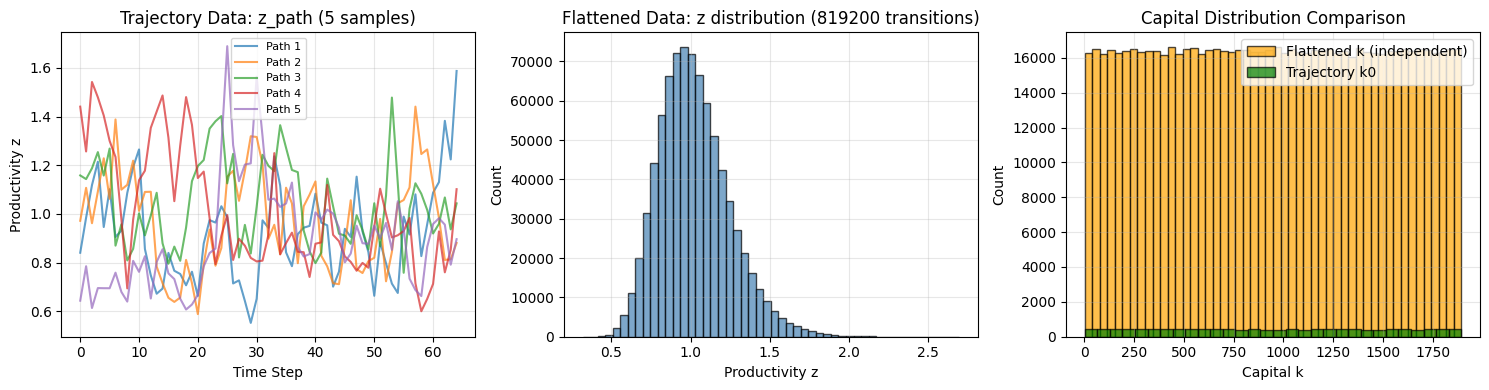


Key Observations:
  - Trajectory data: Time-dependent paths (left)
  - Flattened data: i.i.d. transitions (middle, right)
  - Independent k: Uniformly distributed across state space


In [32]:
# 2.1 Data Format Comparison

# Robust Path Definition
fig_dir = "../figures"
os.makedirs(fig_dir, exist_ok=True) # Ensure directory exists
plot_path = os.path.join(fig_dir, "data_format_comparison.png")

# Compare data formats visually
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Trajectory z_path (first 5 paths)
z_path = traj_data['z_path'].numpy()
for i in range(min(5, z_path.shape[0])):
    axes[0].plot(z_path[i], alpha=0.7, label=f'Path {i+1}')
axes[0].set_title('Trajectory Data: z_path (5 samples)')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Productivity z')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

# Plot 2: Flattened z distribution
z_flat = flat_data['z'].numpy()
axes[1].hist(z_flat, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].set_title(f'Flattened Data: z distribution ({len(z_flat)} transitions)')
axes[1].set_xlabel('Productivity z')
axes[1].set_ylabel('Count')
axes[1].grid(True, alpha=0.3)

# Plot 3: Flattened k distribution (independent sampling)
k_flat = flat_data['k'].numpy()
k_traj = traj_data['k0'].numpy()
axes[2].hist(k_flat, bins=50, alpha=0.7, label='Flattened k (independent)', color='orange', edgecolor='black')
axes[2].hist(k_traj, bins=30, alpha=0.7, label='Trajectory k0', color='green', edgecolor='black')
axes[2].set_title('Capital Distribution Comparison')
axes[2].set_xlabel('Capital k')
axes[2].set_ylabel('Count')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# ROBUST SAVING: Save before show
print(f"Saving figure to {plot_path}...")
fig.savefig(plot_path, dpi=300, bbox_inches='tight')

# Display
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("  - Trajectory data: Time-dependent paths (left)")
print("  - Flattened data: i.i.d. transitions (middle, right)")
print("  - Independent k: Uniformly distributed across state space")


Batch 0 Summary:
------------------------------------------------------------
k0         shape=(12800,)        mean=944.1017 std=550.7701 min=2.1347 max=1892.7875
z0         shape=(12800,)        mean=1.0643 std=0.3820 min=0.5325 max=1.8778
b0         shape=(12800,)        mean=1127.5273 std=652.8874 min=0.0572 max=2262.3826
z_path     shape=(12800, 65)     mean=1.0235 std=0.2236 min=0.3172 max=2.6964
Saved z_path plot to ../data/traj_data_dist_zpath.png
Saved distribution plot to ../data/traj_data_dist.png


<Figure size 640x480 with 0 Axes>

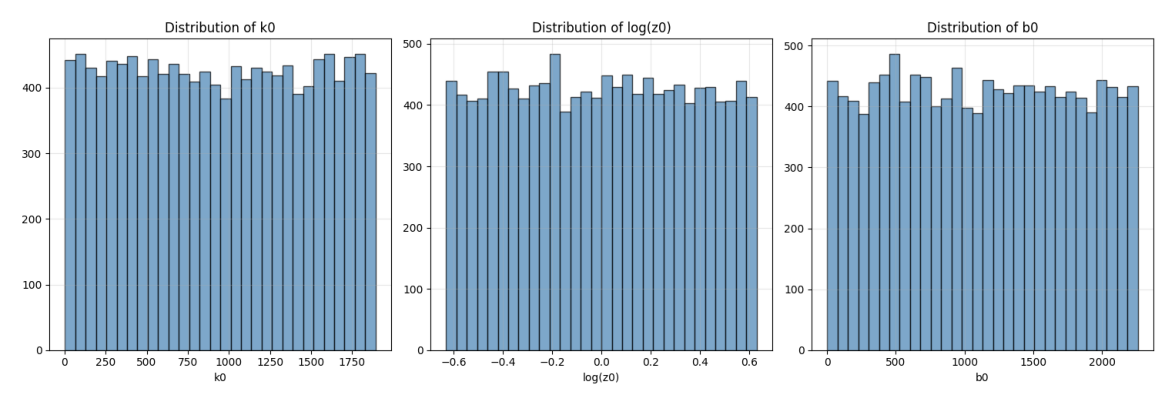

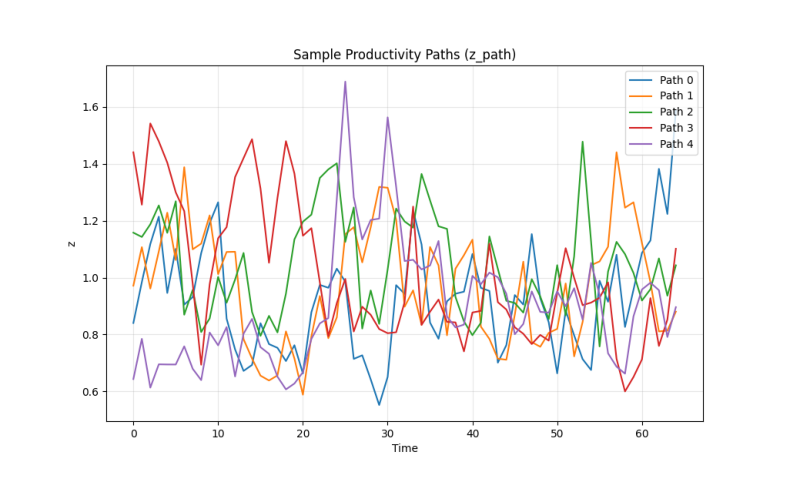

In [33]:
from src.utils.analysis import plot_dataset_stats, summarize_batch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 1. Print numerical stats of a single batch
summarize_batch(traj_data, batch_idx=0)

# Generate plots (saves to file)
# We use a temporary path for the plot
plt.tight_layout()
plot_path = "../data/traj_data_dist.png"
plot_dataset_stats(traj_data, save_path=plot_path)

# Display the saved plots inline
try:
    img = mpimg.imread(plot_path)
    plt.figure(figsize=(15, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    # Also allow checking z_path plot if it was generated
    z_path_img = plot_path.replace(".png", "_zpath.png")
    if os.path.exists(z_path_img):
        img_z = mpimg.imread(z_path_img)
        plt.figure(figsize=(10, 6))
        plt.imshow(img_z)
        plt.axis('off')
        plt.show()
except FileNotFoundError:
    print("Plot file not found/generated.")

In [34]:
# 3. Train Lifetime Reward (LR) Method
method_config_lr = MethodConfig(
    name="basic_lr"
)
print("\n--- LR Method-specific Config ---")
pprint(dataclasses.asdict(method_config_lr))

print("Training LR Method...")
result_lr = train_basic_lr(
    dataset=traj_data,  # Uses FLATTENED data
    net_config=net_config,
    opt_config=opt_config,
    method_config=method_config_lr,
    anneal_config=anneal_config,
    params=params,
    shock_params=shock_params,
    bounds=bounds,
    validation_data=val_traj
)

print("--- LR Training Complete ---")
print(f"  Final loss: {result_lr['history']['loss_LR'][-1]:.6f}")
print(f"  Stopped early: {result_lr['history']['stopped_early']}")
print(f"  Final iteration: {result_lr['history']['final_iteration']}")
print(f"  N_anneal (gatekeeper): {result_lr['history']['n_anneal']}")


--- LR Method-specific Config ---
{'n_critic': 5, 'name': 'basic_lr', 'polyak_tau': 0.995, 'risky': None}
Training LR Method...
Iter 100: loss_LR=-282.8820 Anneal_log=-0.43
Iter 200: loss_LR=-573.1795 Anneal_log=-0.87
Iter 300: loss_LR=-800.6807 Anneal_log=-1.31
Iter 400: loss_LR=-858.1562 Anneal_log=-1.74
Iter 500: loss_LR=-922.2183 Anneal_log=-2.18
--- LR Training Complete ---
  Final loss: -922.218262
  Stopped early: False
  Final iteration: 500
  N_anneal (gatekeeper): 1146


In [35]:
# 4. Train Euler Residual (ER) Method

method_config_er = MethodConfig(
    name="basic_er",
    polyak_tau=0.995  # Target network update rate
)
print("\n--- ER Method-specific Config ---")
pprint(dataclasses.asdict(method_config_er))

print("Training ER Method...")
result_er = train_basic_er(
    dataset=flat_data,  # Uses FLATTENED data
    net_config=net_config,
    opt_config=opt_config,
    method_config=method_config_er,
    anneal_config=anneal_config,
    params=params,
    shock_params=shock_params,
    bounds=bounds,
    validation_data=val_flat
)

print("--- ER Training Complete ---")
print(f"  Final loss: {result_er['history']['loss_ER'][-1]:.6f}")
print(f"  Stopped early: {result_er['history']['stopped_early']}")
print(f"  Final iteration: {result_er['history']['final_iteration']}")


--- ER Method-specific Config ---
{'n_critic': 5, 'name': 'basic_er', 'polyak_tau': 0.995, 'risky': None}
Training ER Method...


/Users/wangzhaoxuan/Desktop/JPM-TSRL/DL_corp_finance/.venv/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:745: UserWarning: Model 'basic_policy_network_8' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)


Iter 100: loss_ER=0.0354 Anneal_log=-0.43
Iter 200: loss_ER=0.0568 Anneal_log=-0.87
Iter 300: loss_ER=0.0109 Anneal_log=-1.31
Iter 400: loss_ER=0.0048 Anneal_log=-1.74
Iter 500: loss_ER=0.0028 Anneal_log=-2.18
--- ER Training Complete ---
  Final loss: 0.002807
  Stopped early: False
  Final iteration: 500


In [36]:
# 5. Train Bellman Residual (BR) Method
method_config_br = MethodConfig(
    name="basic_br",
    n_critic=20,  # critic updates per actor update
    polyak_tau=0.995  # Target network update rate
)

print("Training BR Method...")
result_br = train_basic_br(
    dataset=flat_data,  # Uses FLATTENED data
    net_config=net_config,
    opt_config=opt_config,
    method_config=method_config_br,
    anneal_config=anneal_config,
    params=params,
    shock_params=shock_params,
    bounds=bounds,
    validation_data=val_flat
)

print("--- BR Training Complete ---")
print(f"  Final critic loss: {result_br['history']['loss_critic'][-1]:.6f}")
print(f"  Stopped early: {result_br['history']['stopped_early']}")
print(f"  Final iteration: {result_br['history']['final_iteration']}")

Training BR Method...


/Users/wangzhaoxuan/Desktop/JPM-TSRL/DL_corp_finance/.venv/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:745: UserWarning: Model 'basic_policy_network_10' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)
/Users/wangzhaoxuan/Desktop/JPM-TSRL/DL_corp_finance/.venv/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:745: UserWarning: Model 'basic_value_network_8' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that ge

Iter 100: loss_critic=8372.6876 Anneal_log=-0.43
Iter 200: loss_critic=285.1272 Anneal_log=-0.87
Iter 300: loss_critic=1807.0145 Anneal_log=-1.31
Iter 400: loss_critic=18.4379 Anneal_log=-1.74
Iter 500: loss_critic=50.5075 Anneal_log=-2.18
--- BR Training Complete ---
  Final critic loss: 50.507451
  Stopped early: False
  Final iteration: 500


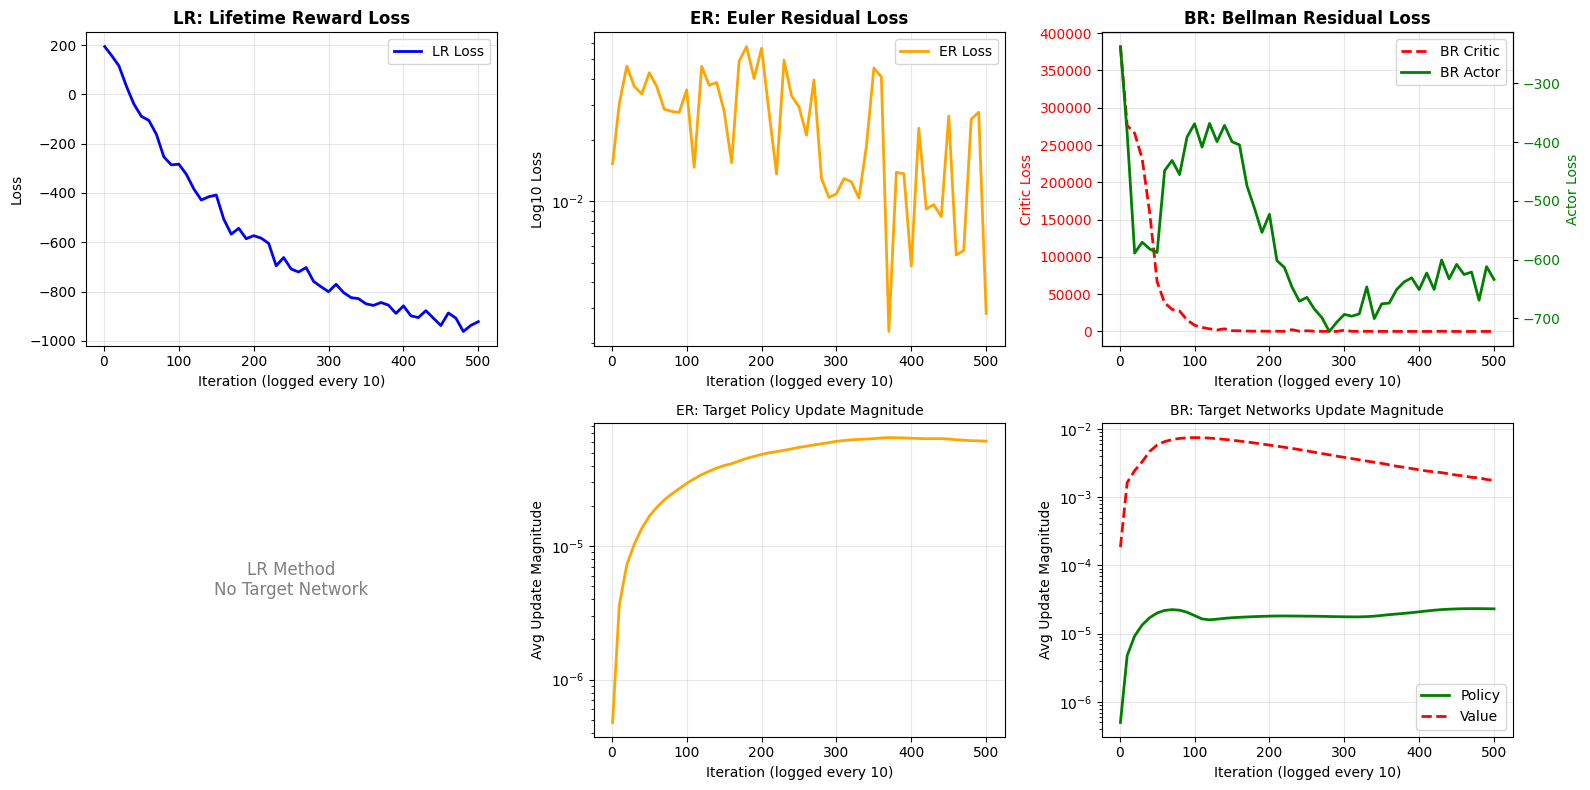


Target Network Updates:
  ER: Final target policy update = 6.111170e-05
  BR: Final target policy update = 2.312251e-05
  BR: Final target value update  = 1.760528e-03


In [37]:
# 6. Loss Curves and Target Network Updates

# Dynamic label for x-axis
freq_str = f"Iteration (logged every {opt_config.log_every})"

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

# Row 1: Main losses
# 1.1 Lifetime Reward
iter_lr = result_lr['history']['iteration']
axes[0, 0].plot(iter_lr, result_lr['history']['loss_LR'], label='LR Loss', color='blue', linewidth=2)
axes[0, 0].set_title('LR: Lifetime Reward Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel(freq_str)
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 1.2 Euler Residual
iter_er = result_er['history']['iteration']
axes[0, 1].plot(iter_er, result_er['history']['loss_ER'], label='ER Loss', color='orange', linewidth=2)
axes[0, 1].set_title('ER: Euler Residual Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel(freq_str)
axes[0, 1].set_ylabel('Log10 Loss')
axes[0, 1].legend()
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# 1.3 Bellman Residual (Dual Axis)
ax_br = axes[0, 2]
iter_br = result_br['history']['iteration']

# Critic on primary Y
line1 = ax_br.plot(iter_br, result_br['history']['loss_critic'], label='BR Critic', color='red', linewidth=2, linestyle='--')
ax_br.set_ylabel('Critic Loss', color='red')
ax_br.tick_params(axis='y', labelcolor='red')

# Actor on secondary Y
ax_br2 = ax_br.twinx()
line2 = ax_br2.plot(iter_br, result_br['history']['loss_actor'], label='BR Actor', color='green', linewidth=2)
ax_br2.set_ylabel('Actor Loss', color='green')
ax_br2.tick_params(axis='y', labelcolor='green')

# Combined Legend
lines = line1 + line2
labels_box = [l.get_label() for l in lines]
ax_br.legend(lines, labels_box, loc='upper right')

ax_br.set_title('BR: Bellman Residual Loss', fontsize=12, fontweight='bold')
ax_br.set_xlabel(freq_str)
ax_br.grid(True, alpha=0.3)

# Row 2: Target network updates (ER and BR only)
# 2.1 Empty (LR has no target network)
axes[1, 0].text(0.5, 0.5, 'LR Method\nNo Target Network', ha='center', va='center', fontsize=12, color='gray')
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])
axes[1, 0].spines['top'].set_visible(False)
axes[1, 0].spines['right'].set_visible(False)
axes[1, 0].spines['bottom'].set_visible(False)
axes[1, 0].spines['left'].set_visible(False)

# 2.2 ER Target Policy Update
if 'target_policy_update' in result_er['history']:
    axes[1, 1].plot(iter_er, result_er['history']['target_policy_update'], color='orange', linewidth=2)
    axes[1, 1].set_title('ER: Target Policy Update Magnitude', fontsize=10)
    axes[1, 1].set_xlabel(freq_str)
    axes[1, 1].set_ylabel('Avg Update Magnitude')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No target update data', ha='center', va='center', color='gray')

# 2.3 BR Target Networks Update
if 'target_policy_update' in result_br['history'] and 'target_value_update' in result_br['history']:
    axes[1, 2].plot(iter_br, result_br['history']['target_policy_update'], label='Policy', color='green', linewidth=2)
    axes[1, 2].plot(iter_br, result_br['history']['target_value_update'], label='Value', color='red', linewidth=2, linestyle='--')
    axes[1, 2].set_title('BR: Target Networks Update Magnitude', fontsize=10)
    axes[1, 2].set_xlabel(freq_str)
    axes[1, 2].set_ylabel('Avg Update Magnitude')
    axes[1, 2].set_yscale('log')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
else:
    axes[1, 2].text(0.5, 0.5, 'No target update data', ha='center', va='center', color='gray')

plt.tight_layout()
plt.show()

print("\nTarget Network Updates:")
if 'target_policy_update' in result_er['history']:
    print(f"  ER: Final target policy update = {result_er['history']['target_policy_update'][-1]:.6e}")
if 'target_policy_update' in result_br['history']:
    print(f"  BR: Final target policy update = {result_br['history']['target_policy_update'][-1]:.6e}")
    print(f"  BR: Final target value update  = {result_br['history']['target_value_update'][-1]:.6e}")

In [38]:
# 8. Summary Statistics

# Create summary table
summary_data = {
    'Method': ['LR', 'ER', 'BR'],
    'Data Format': ['Trajectory', 'Flattened', 'Flattened'],
    'Target Network': ['No', 'Yes (Policy)', 'Yes (Policy+Value)'],
    'Final Loss': [
        result_lr['history']['loss_LR'][-1],
        result_er['history']['loss_ER'][-1],
        result_br['history']['loss_critic'][-1]
    ],
    'Data Samples': [
        f"{traj_data['k0'].shape[0]} traj.",
        f"{flat_data['k'].shape[0]} trans.",
        f"{flat_data['k'].shape[0]} trans."
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)

# Additional details
print("\nKey Observations:")
print(f"  - LR uses {traj_data['z_path'].shape[1]-1} timesteps per trajectory")
print(f"  - ER/BR use {flat_data['k'].shape[0] / traj_data['k0'].shape[0]:.0f}× more data samples (flattened)")
print(f"  - ER/BR benefit from target networks (Polyak tau = {method_config_er.polyak_tau})")
print(f"  - BR uses {method_config_br.n_critic} critic steps per actor update")

print("\n✓ Demo complete!")


TRAINING SUMMARY
Method Data Format     Target Network  Final Loss  Data Samples
    LR  Trajectory                 No -922.218262   12800 traj.
    ER   Flattened       Yes (Policy)    0.002807 819200 trans.
    BR   Flattened Yes (Policy+Value)   50.507451 819200 trans.

Key Observations:
  - LR uses 64 timesteps per trajectory
  - ER/BR use 64× more data samples (flattened)
  - ER/BR benefit from target networks (Polyak tau = 0.995)
  - BR uses 20 critic steps per actor update

✓ Demo complete!


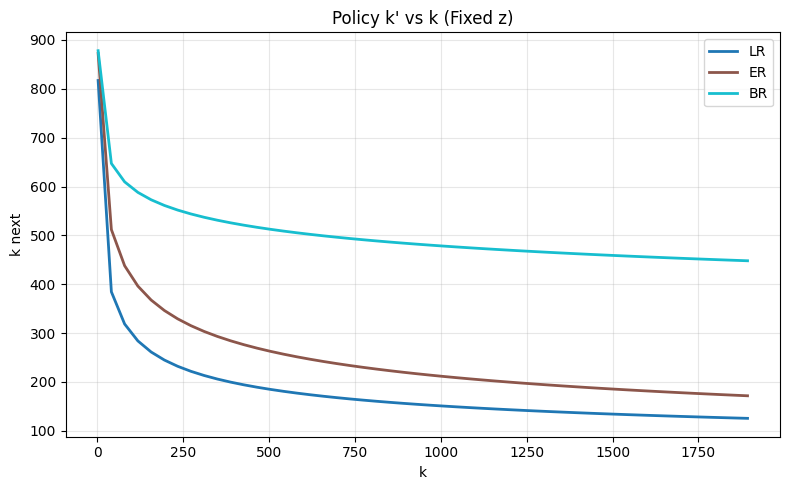

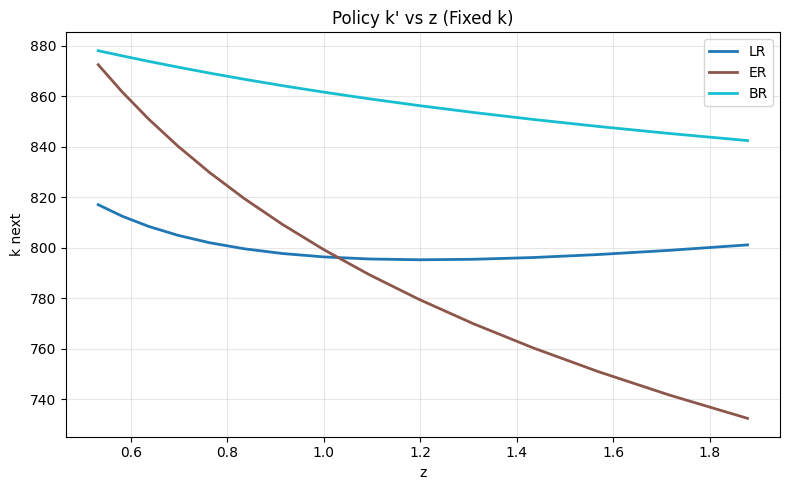

In [39]:

# 7. Policy Comparison

# Evaluate all policies on the same grid
eval_lr = evaluate_policy(result_lr['_policy_net'], bounds['k'], bounds['log_z'])
eval_er = evaluate_policy(result_er['_policy_net'], bounds['k'], bounds['log_z'])
eval_br = evaluate_policy(result_br['_policy_net'], bounds['k'], bounds['log_z'])

eval_datas = [eval_lr, eval_er, eval_br]
labels = ["LR", "ER", "BR"]

# Plot Slices
fig_k = plot_scenario_comparison(
    eval_datas, labels, x_key='k', y_key='k_next', fixed_key='fixed_z_val', 
    title="Policy k' vs k (Fixed z)"
)
plt.show()

fig_z = plot_scenario_comparison(
    eval_datas, labels, x_key='z', y_key='k_next', fixed_key='fixed_k_val', 
    title="Policy k' vs z (Fixed k)"
)
plt.show()



---

# Risky Debt Model: BR Method

This section demonstrates the **Bellman Residual (BR) method** for the Risky Debt model.

**Key Differences from Basic Model:**
- **Three Networks**: Policy $(k,b,z) \to (k',b')$, Value $(k,b,z) \to \widetilde{V}$, Price $(k',b',z) \to q$
- **Target Networks**: All three networks have corresponding target networks with Polyak averaging
- **Bond Pricing**: Price network outputs bond price $q \in [0, 1/(1+r)]$ instead of interest rate
- **Default Probability**: Uses Gumbel-Sigmoid for smooth exploration around default boundary
- **Effective Value**: $V_{eff} = (1-p) \cdot V$ where $p$ is default probability

**Reference**: `report_brief.md` lines 917-1082

In [40]:
# Risky Debt Imports
from src.trainers.risky import train_risky_br
from src.networks.network_risky import build_risky_networks, compute_effective_value

print("✓ Risky Debt modules imported")

✓ Risky Debt modules imported


In [41]:
# Risky Debt Configuration

# Economic parameters with risky debt costs enabled
params_risky = EconomicParams.with_overrides(
    cost_convex=0.5,           # Convex adjustment cost
    cost_fixed=0.01,            # Fixed adjustment cost (disabled for simplicity)
    cost_inject_fixed=0.02,    # Fixed equity injection cost
    cost_inject_linear=0.05,   # Linear equity injection cost
    cost_default=0.4,          # Deadweight default cost (alpha)
    tax=0.3                    # Corporate tax rate
)

# AR(1) shock params
shock_params = ShockParams(mu=0.0, rho=0.7, sigma=0.15)

# Network config (same architecture as basic)
net_config_risky = NetworkConfig(
    n_layers=2,
    n_neurons=32,
    activation="swish"
)

# Annealing Config
anneal_config = AnnealingConfig(
    temperature_init=1.0,
    temperature_min=1e-4,
    decay=0.99   # Set slow decay for gate keeping
)

# Risky-debt specific configuration
risky_debt_config = RiskyDebtConfig(
    weight_br=1e-3          # Weight on BR loss in critic
)

# Method config for Risky BR
method_config_risky_br = MethodConfig(
    name="risky_br",
    n_critic=10,                # Critic updates per actor update
    polyak_tau=0.995,          # Target network update rate
    risky=risky_debt_config
)

# Early stopping config
early_stopping_config = EarlyStoppingConfig(
    enabled=True,           # Enable early stopping (False = run exactly n_iter)
    patience=5,             # Stop after 5 consecutive checks meeting criteria
    eval_freq=50,          # Check convergence every 100 iterations
    
    # BR Method: Dual-Condition Convergence
    br_critic_epsilon=1e-5, # Critic loss threshold
    br_actor_epsilon=1e-4   # Actor relative improvement threshold
)

# Optimization config (can use different LR for actor/critic)
opt_config_risky = OptimizationConfig(
    learning_rate=1e-4,        # Actor learning rate
    learning_rate_critic=1e-3, # Critic learning rate  
    batch_size=256,
    n_iter=500,                # Fewer for demo, more to allow for convergence
    log_every=10,
    early_stopping=early_stopping_config      
)

print("✓ Risky Debt configuration set")
print(f"  Default temp: {anneal_config.temperature_init} → {anneal_config.temperature_min}")
print(f"  Critic steps: {method_config_risky_br.n_critic}, Polyak τ: {method_config_risky_br.polyak_tau}")

✓ Risky Debt configuration set
  Default temp: 1.0 → 0.0001
  Critic steps: 10, Polyak τ: 0.995


In [42]:
# Generate Risky Debt Data (with debt dimension)

print("Creating risky debt data generator...")
generator_risky, _, bounds_risky = create_data_generator(
    master_seed=(20, 26),
    T=64,
    sim_batch_size=128,
    n_sim_batches=50,
    shock_params=shock_params,
    cache_dir="../data",
    save_to_disk=False,  # Don't cache to avoid conflicts
    verbose=True
    # No bounds override -> auto-compute all (k, log_z, b) from economic params
    # b_max is computed from max repayment capacity at (k_max, z_max)
)

# Get flattened data WITH debt dimension
flat_data_risky = generator_risky.get_flattened_training_dataset(include_debt=True)

print(f"\n Risky debt data generated")
print(f"  Transitions: {flat_data_risky['k'].shape[0]}")
print(f"  State space: k ∈ [{bounds_risky['k'][0]:.2f}, {bounds_risky['k'][1]:.2f}]")
print(f"               b ∈ [{bounds_risky['b'][0]:.2f}, {bounds_risky['b'][1]:.2f}]")
print(f"           log_z ∈ [{bounds_risky['log_z'][0]:.2f}, {bounds_risky['log_z'][1]:.2f}]")
print(f"  Data keys: {list(flat_data_risky.keys())}")

Creating risky debt data generator...
 Using provided ShockParams
 Auto-generated missing SamplingBounds
  k_bounds: (1.8907927226966654, 1892.9403205389913)
  log_z_bounds: (-0.6301260378126043, 0.6301260378126043)
  b_bounds: (0.0, 2262.4757700180035)
  Master seed: (20, 26)
 === DataGenerator created ===
  Simulation batch size (n): 128
  Horizon (T): 64
  Simulation batches (J): 50
  Total samples: 6400

 Risky debt data generated
  Transitions: 409600
  State space: k ∈ [1.89, 1892.94]
               b ∈ [0.00, 2262.48]
           log_z ∈ [-0.63, 0.63]
  Data keys: ['k', 'z', 'z_next_main', 'z_next_fork', 'b']


In [43]:
# Train Risky Debt BR Method

print("Training Risky Debt BR Method...")
print(f"  This uses Actor-Critic with target networks for policy, value, and price networks.")
print()

result_risky_br = train_risky_br(
    dataset=flat_data_risky,
    net_config=net_config_risky,
    opt_config=opt_config_risky,
    method_config=method_config_risky_br,
    anneal_config=anneal_config,
    params=params_risky,
    shock_params=shock_params,
    bounds=bounds_risky
)

print("\n✓ Risky Debt BR Training Complete")
print(f"  Final critic loss: {result_risky_br['history']['loss_critic'][-1]:.6f}")
print(f"  Final actor loss:  {result_risky_br['history']['loss_actor'][-1]:.6f}")
print(f"  Final price loss:  {result_risky_br['history']['loss_price'][-1]:.6f}")

Training Risky Debt BR Method...
  This uses Actor-Critic with target networks for policy, value, and price networks.



/Users/wangzhaoxuan/Desktop/JPM-TSRL/DL_corp_finance/.venv/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:745: UserWarning: Model 'risky_policy_network_3' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)
/Users/wangzhaoxuan/Desktop/JPM-TSRL/DL_corp_finance/.venv/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:745: UserWarning: Model 'risky_value_network_3' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that gen

Iter 100: loss_critic=1926463.1250 Anneal_log=-0.43
Iter 200: loss_critic=4863367.0500 Anneal_log=-0.87
Iter 300: loss_critic=20076216.8000 Anneal_log=-1.31
Iter 400: loss_critic=6417792.0000 Anneal_log=-1.74
Iter 500: loss_critic=685356.7375 Anneal_log=-2.18

✓ Risky Debt BR Training Complete
  Final critic loss: 685356.737500
  Final actor loss:  -411.758942
  Final price loss:  23303.193555


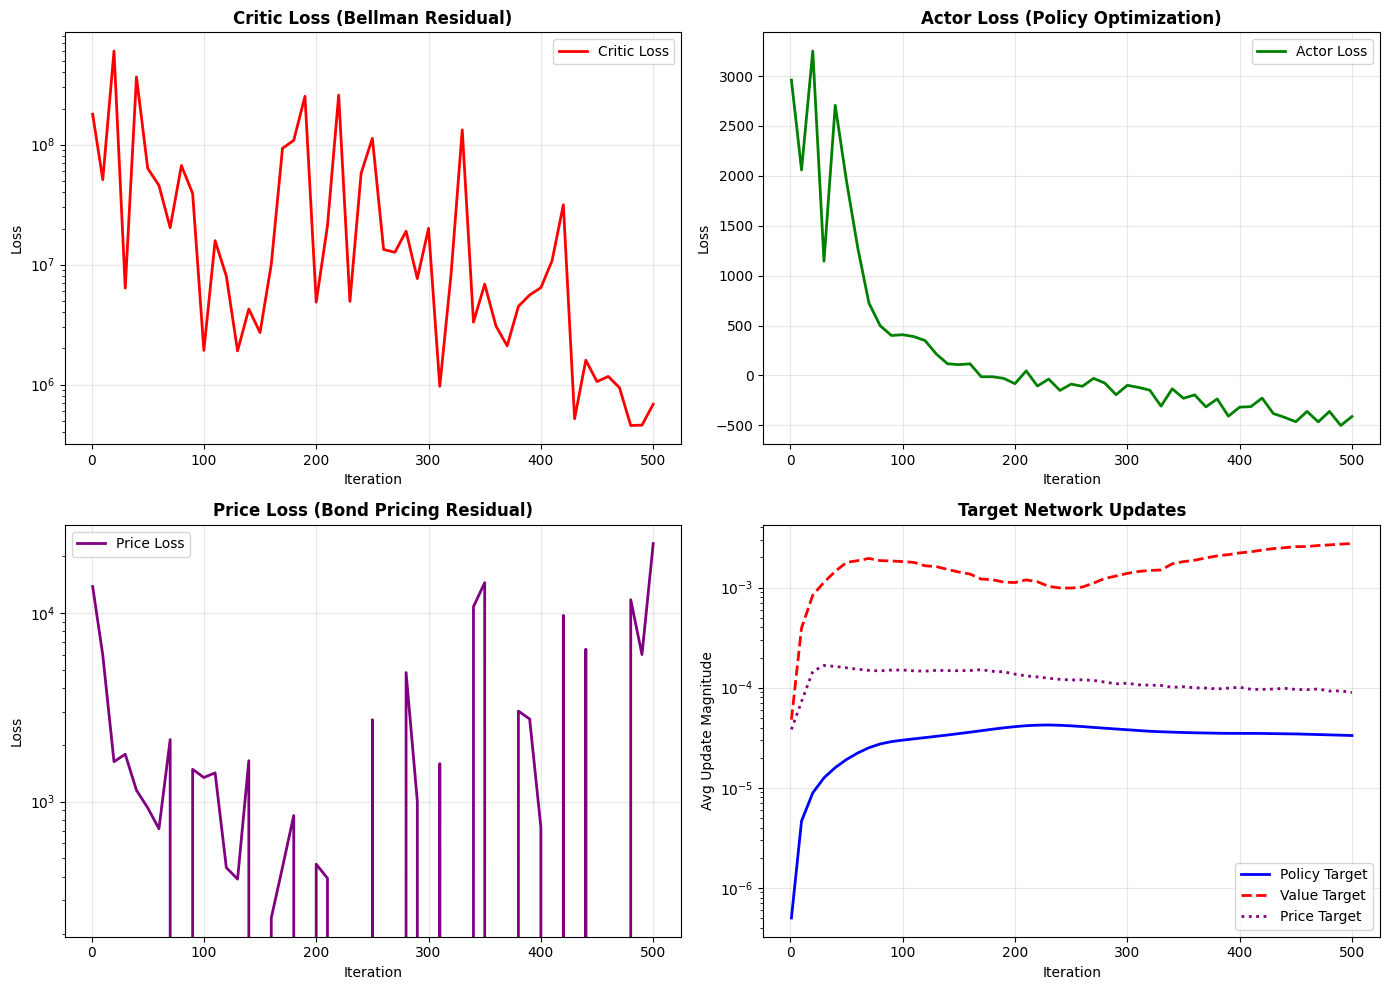

✓ Figure saved to ../figures/risky_br_loss_curves.png


In [ ]:
# Risky Debt BR: Loss Curves Visualization

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
iter_risky = result_risky_br['history']['iteration']

# 1. Critic Loss (Bellman Residual)
axes[0, 0].plot(iter_risky, result_risky_br['history']['loss_critic'], 
                color='red', linewidth=2, label='Critic Loss')
axes[0, 0].set_title('Critic Loss (Bellman Residual)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2. Actor Loss (Policy Gradient)
axes[0, 1].plot(iter_risky, result_risky_br['history']['loss_actor'], 
                color='green', linewidth=2, label='Actor Loss')
axes[0, 1].set_title('Actor Loss (Policy Optimization)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 3. Price Loss (Bond Pricing Residual)
axes[1, 0].plot(iter_risky, result_risky_br['history']['loss_price'], 
                color='purple', linewidth=2, label='Price Loss')
axes[1, 0].set_title('Price Loss (Bond Pricing Residual)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# 4. Target Network Updates (if available)
has_target_data = ('target_policy_update' in result_risky_br['history'] and 
                   'target_value_update' in result_risky_br['history'])

if has_target_data:
    axes[1, 1].plot(iter_risky, result_risky_br['history']['target_policy_update'], 
                    label='Policy Target', color='blue', linewidth=2)
    axes[1, 1].plot(iter_risky, result_risky_br['history']['target_value_update'], 
                    label='Value Target', color='red', linewidth=2, linestyle='--')
    if 'target_price_update' in result_risky_br['history']:
        axes[1, 1].plot(iter_risky, result_risky_br['history']['target_price_update'], 
                        label='Price Target', color='purple', linewidth=2, linestyle=':')
    axes[1, 1].set_title('Target Network Updates', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Iteration')
    axes[1, 1].set_ylabel('Avg Update Magnitude')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
else:
    # Summary stats instead
    axes[1, 1].axis('off')
    summary_text = (
        f"Risky Debt BR Summary\n"
        f"{'='*30}\n\n"
        f"Final Critic Loss: {result_risky_br['history']['loss_critic'][-1]:.4f}\n"
        f"Final Actor Loss:  {result_risky_br['history']['loss_actor'][-1]:.4f}\n"
        f"Final Price Loss:  {result_risky_br['history']['loss_price'][-1]:.4f}\n\n"
        f"Iterations: {len(iter_risky) * opt_config_risky.log_every}\n"
        f"Batch Size: {opt_config_risky.batch_size}\n"
        f"Critic Steps: {method_config_risky_br.n_critic}\n"
        f"Polyak τ: {method_config_risky_br.polyak_tau}"
    )
    axes[1, 1].text(0.1, 0.5, summary_text, transform=axes[1, 1].transAxes,
                    fontsize=11, verticalalignment='center', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig("../figures/risky_br_loss_curves.png", dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved to ../figures/risky_br_loss_curves.png")